<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

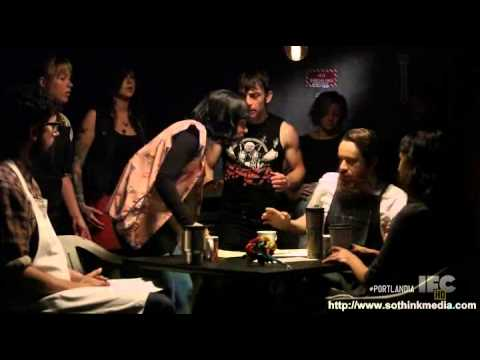

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\crlga\\Documents\\GitHub\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [95]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [96]:
# Technically this is somewhat copy and paste,
# but I also helped write it in the first place,
# so I'd count it as quid pro quo

date_pattern = r'(\d+\/\d+\/\d{4} )'
check_ins_pattern = r'(\d) check-ins? '
star_pattern = r'(\d\.\d)'
shops['date'] = shops['full_review_text'].str.extract(date_pattern)
shops['date'] = pd.to_datetime(shops['date'], errors='ignore')
shops['check_ins'] = shops['full_review_text'].str.extract(check_ins_pattern)
shops['check_ins'] = shops['check_ins'].fillna(0).apply(int)
shops['star_rating'] = shops['star_rating'].str.extract(star_pattern)
shops['star_rating'] = shops['star_rating'].str.strip().apply(float)
shops['full_review_text'] = shops['full_review_text'].str.replace(date_pattern, "").str.replace(check_ins_pattern, "").str.strip()
shops.head()

,coffee_shop_name,full_review_text,star_rating,date,check_ins
0,The Factory - Cafe With a Soul,Love love loved the atmosphere! Every corner o...,5.0,2016-11-25,1
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,2016-12-02,0
2,The Factory - Cafe With a Soul,Listed in Brunch Spots I loved the eclectic an...,4.0,2016-11-30,1
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,2016-11-25,0
4,The Factory - Cafe With a Soul,They are located within the Northcross mall sh...,4.0,2016-12-03,1


In [99]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [105]:
STOP_WORDS = nlp.Defaults.stop_words

lemmas = pd.Series([[token.lemma_.lower() for token in doc if token.lemma_.lower() not in STOP_WORDS] for doc in nlp.pipe(shops['full_review_text'], batch_size=500)])
shops['lemmas'] = lemmas

In [106]:
# Object from Base Python
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
wc = count(shops['lemmas'])

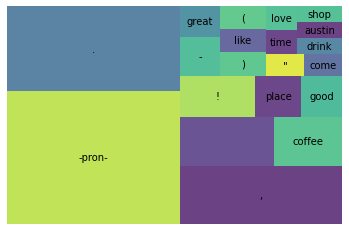

In [107]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [108]:
STOP_WORDS = nlp.Defaults.stop_words.union({'-pron-', '-', '(', ')', '"', '!', ',', 'coffee', 'austin'})

In [109]:
lemmas = pd.Series([[token.lemma_.lower() for token in doc if token.lemma_.lower() not in STOP_WORDS] for doc in nlp.pipe(shops['full_review_text'], batch_size=500)])
lemmas.head(20)
shops['lemmas'] = lemmas

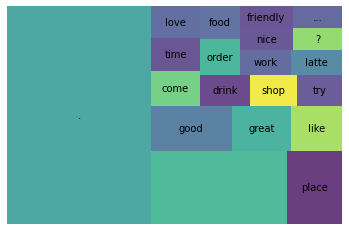

In [110]:
wc = count(shops['lemmas'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

